In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
data = pd.read_sql_query("SELECT * FROM film", engine)
data.head()

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2006-02-15 05:03:42
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2006-02-15 05:03:42
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2006-02-15 05:03:42
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,6,2.99,130,22.99,G,Deleted Scenes,2006-02-15 05:03:42


***In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.***

In [4]:
query = '''select distinct f.title,
max(case 
     when r.rental_date between "2005-05-01" and "2005-05-31" then TRUE
	else FALSE
end) as "rented_in_may"
from film as f
left join inventory as i
on f.film_id = i.film_id
left join rental as r
on i.inventory_id = r.inventory_id
GROUP BY f.title
;'''

rented_may2005 = pd.read_sql_query(query, engine)
rented_may2005.head()

,title,rented_in_may
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,0
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1


***Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).***

In [5]:
query = """
SELECT f.title, 
       MAX(f.film_id) AS film_id, 
       MAX(f.release_year) AS release_year, 
       MAX(f.rental_duration) AS rental_duration, 
       MAX(f.rental_rate) AS rental_rate, 
       MAX(f.length) AS length, 
       MAX(f.rating) AS rating, 
       MAX(r.rental_date) AS rental_date,
       CASE 
         WHEN COUNT(CASE WHEN EXTRACT(YEAR_MONTH FROM rental_date) = '200505' THEN 1 END) > 0 
         THEN TRUE 
         ELSE FALSE 
       END AS rented_in_may
FROM film f
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
GROUP BY f.title;
"""

data = pd.read_sql_query(query, engine)
data.head()

,title,film_id,release_year,rental_duration,rental_rate,length,rating,rental_date,rented_in_may
0,ACADEMY DINOSAUR,1,2006,6,0.99,86,PG,2023-05-04 01:50:21,1
1,ACE GOLDFINGER,2,2006,3,4.99,48,G,2006-02-14 15:16:03,0
2,ADAPTATION HOLES,3,2006,7,2.99,50,NC-17,2005-08-23 13:54:39,1
3,AFFAIR PREJUDICE,4,2006,5,2.99,117,G,2006-02-14 15:16:03,1
4,AFRICAN EGG,5,2006,6,2.99,130,G,2006-02-14 15:16:03,1


***Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.***

In [6]:
data["rented_in_may"] = data["rented_in_may"].replace({0: False, 1: True})
data

,title,film_id,release_year,rental_duration,rental_rate,length,rating,rental_date,rented_in_may
0,ACADEMY DINOSAUR,1,2006,6,0.99,86,PG,2023-05-04 01:50:21,True
1,ACE GOLDFINGER,2,2006,3,4.99,48,G,2006-02-14 15:16:03,False
2,ADAPTATION HOLES,3,2006,7,2.99,50,NC-17,2005-08-23 13:54:39,True
3,AFFAIR PREJUDICE,4,2006,5,2.99,117,G,2006-02-14 15:16:03,True
4,AFRICAN EGG,5,2006,6,2.99,130,G,2006-02-14 15:16:03,True
...,...,...,...,...,...,...,...,...,...
953,YOUNG LANGUAGE,996,2006,6,0.99,183,G,2005-08-23 01:50:31,False
954,YOUTH KICK,997,2006,4,0.99,179,NC-17,2005-08-18 17:31:36,False
955,ZHIVAGO CORE,998,2006,6,0.99,105,NC-17,2006-02-14 15:16:03,True
956,ZOOLANDER FICTION,999,2006,5,2.99,101,R,2005-08-23 08:48:43,True


***Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.***

In [7]:
data.isna().sum()

title              0
film_id            0
release_year       0
rental_duration    0
rental_rate        0
length             0
rating             0
rental_date        0
rented_in_may      0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            958 non-null    object        
 1   film_id          958 non-null    int64         
 2   release_year     958 non-null    int64         
 3   rental_duration  958 non-null    int64         
 4   rental_rate      958 non-null    float64       
 5   length           958 non-null    int64         
 6   rating           958 non-null    object        
 7   rental_date      958 non-null    datetime64[ns]
 8   rented_in_may    958 non-null    bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 60.9+ KB


In [9]:
data.shape

(958, 9)

***Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.***

In [10]:
X_num = data.select_dtypes(include='number')
X_cat = data.select_dtypes(include='object')
y = data['rented_in_may']

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [12]:
X_cat 

,title,rating
0,ACADEMY DINOSAUR,PG
1,ACE GOLDFINGER,G
2,ADAPTATION HOLES,NC-17
3,AFFAIR PREJUDICE,G
4,AFRICAN EGG,G
...,...,...
953,YOUNG LANGUAGE,G
954,YOUTH KICK,NC-17
955,ZHIVAGO CORE,NC-17
956,ZOOLANDER FICTION,R


In [13]:
X_cat = pd.get_dummies(X_cat['rating'])
X_cat

,G,NC-17,PG,PG-13,R
0,0,0,1,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
953,1,0,0,0,0
954,0,1,0,0,0
955,0,1,0,0,0
956,0,0,0,0,1


In [14]:
minMax = MinMaxScaler()
minMax.fit(X_num)
X_minmax_scaled = minMax.transform(X_num)
X_minmax_scaled = pd.DataFrame(X_minmax_scaled,columns=X_num.columns)
X_minmax_scaled

,film_id,release_year,rental_duration,rental_rate,length
0,0.000000,0.0,0.75,0.0,0.287770
1,0.001001,0.0,0.00,1.0,0.014388
2,0.002002,0.0,1.00,0.5,0.028777
3,0.003003,0.0,0.50,0.5,0.510791
4,0.004004,0.0,0.75,0.5,0.604317
...,...,...,...,...,...
953,0.995996,0.0,0.75,0.0,0.985612
954,0.996997,0.0,0.25,0.0,0.956835
955,0.997998,0.0,0.75,0.0,0.424460
956,0.998999,0.0,0.50,0.5,0.395683


In [15]:
X = pd.concat([X_num, X_cat], axis=1)
X

,film_id,release_year,rental_duration,rental_rate,length,G,NC-17,PG,PG-13,R
0,1,2006,6,0.99,86,0,0,1,0,0
1,2,2006,3,4.99,48,1,0,0,0,0
2,3,2006,7,2.99,50,0,1,0,0,0
3,4,2006,5,2.99,117,1,0,0,0,0
4,5,2006,6,2.99,130,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
953,996,2006,6,0.99,183,1,0,0,0,0
954,997,2006,4,0.99,179,0,1,0,0,0
955,998,2006,6,0.99,105,0,1,0,0,0
956,999,2006,5,2.99,101,0,0,0,0,1


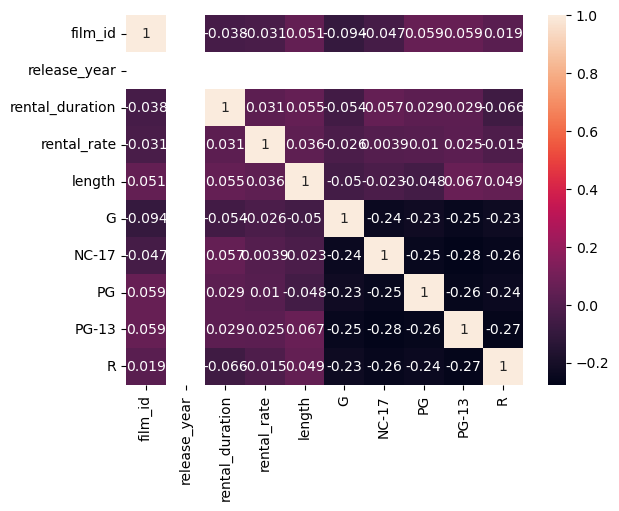

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

correlations_matrix = X.corr()
sns.heatmap(correlations_matrix, annot=True)

plt.show()

In [17]:
X.drop(['release_year'], axis=1)

,film_id,rental_duration,rental_rate,length,G,NC-17,PG,PG-13,R
0,1,6,0.99,86,0,0,1,0,0
1,2,3,4.99,48,1,0,0,0,0
2,3,7,2.99,50,0,1,0,0,0
3,4,5,2.99,117,1,0,0,0,0
4,5,6,2.99,130,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
953,996,6,0.99,183,1,0,0,0,0
954,997,4,0.99,179,0,1,0,0,0
955,998,6,0.99,105,0,1,0,0,0
956,999,5,2.99,101,0,0,0,0,1


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(718, 10)
(240, 10)
(718,)
(240,)


In [20]:
transformer = StandardScaler()
transformer.fit(X_train)

X_train_scaled_np = transformer.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns, index=X_train.index) 
X_test_scaled_np = transformer.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled_np , columns=X_test.columns, index=X_test.index)
X_train_scaled.head()

,film_id,release_year,rental_duration,rental_rate,length,G,NC-17,PG,PG-13,R
162,-1.119143,0.0,0.704430,1.229020,1.634594,-0.447961,1.945936,-0.489968,-0.552679,-0.494335
624,0.532691,0.0,-1.435686,-1.222192,0.283773,-0.447961,-0.513892,-0.489968,-0.552679,2.022918
346,-0.452189,0.0,0.704430,-1.222192,0.959183,-0.447961,-0.513892,-0.489968,-0.552679,2.022918
571,0.342627,0.0,-0.008942,1.229020,1.734655,2.232338,-0.513892,-0.489968,-0.552679,-0.494335
947,1.700725,0.0,-1.435686,-1.222192,1.409457,-0.447961,-0.513892,-0.489968,1.809367,-0.494335


***Create a logistic regression model to predict 'rented_in_may' from the cleaned data.***

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

lr = LogisticRegression(max_iter=250)
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)

print("The accuracy of the model in the TEST set is: {:.2f}".format(lr.score(X_train_scaled, y_train)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_train,y_pred_train, average='weighted')))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_train,y_pred_train, average='weighted')))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_train,y_pred_train, average='weighted')))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))

The accuracy of the model in the TEST set is: 0.66
The precision in the TEST set is: 0.52
The recall in the TEST set is: 0.72
The F1 in the TEST set is: 0.61
The Kappa in the TEST set is: 0.00


C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
lr = LogisticRegression(max_iter=250)
lr.fit(X_test, y_test)
y_pred_test = lr.predict(X_test)

print("The accuracy of the model in the TEST set is: {:.2f}".format(lr.score(X_test_scaled, y_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test, average='weighted')))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test, average='weighted')))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test, average='weighted')))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))

The accuracy of the model in the TEST set is: 0.50
The precision in the TEST set is: 0.48
The recall in the TEST set is: 0.69
The F1 in the TEST set is: 0.57
The Kappa in the TEST set is: 0.00


C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


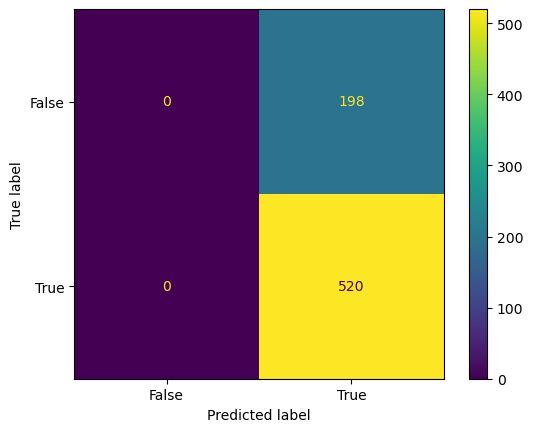

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_test = confusion_matrix(y_train,y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()

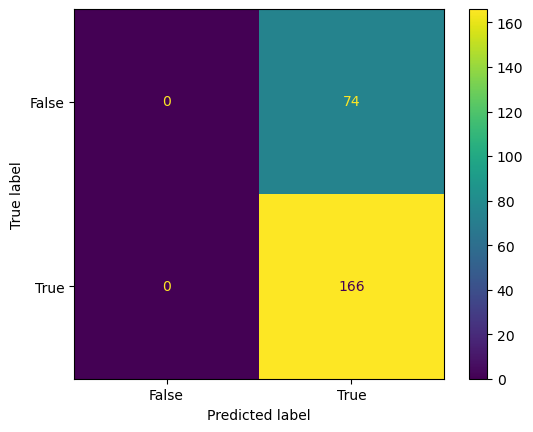

In [24]:
cm_test = confusion_matrix(y_test,y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
disp.plot()
plt.show()